*Use this notebook to complete the sentence similarity and embedding visualization tasks.*


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Assignment_2

/content/drive/MyDrive/Assignment_2


# Part 6: Inspecting and comparing embeddings (28 points)

## Sentence Similarity

In [19]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 100.6 MB/s eta 0:00:00


In [22]:
import nltk
try:
    nltk.data.find('tokenizers/punkt_tab/english')
except LookupError:
    nltk.download('punkt_tab')

import pickle
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors, Word2Vec

In [24]:
def tokenize_text(text):
    return word_tokenize(text.lower())

def load_embeddings(pkl_path):
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f)
    return data['embeddings'], data['word2idx'], data['idx2word']

In [23]:
def sentence_embedding(sentence, source_type, embeddings, word2idx=None):
    tokens = tokenize_text(sentence)
    vectors = []

    if source_type == "skipgram":
        for token in tokens:
            idx = word2idx.get(token, None)
            if idx is not None:
                vectors.append(embeddings[idx])
        dim = embeddings.shape[1]
    else:
        for token in tokens:
            if token in embeddings:
                vectors.append(embeddings[token])
        dim = embeddings.vector_size

    if len(vectors) == 0:
        return np.zeros(dim)

    return np.mean(vectors, axis=0)


def compute_similarity(query, sentences, source_type, embeddings, word2idx=None):
    query_vec = sentence_embedding(
        query, source_type, embeddings, word2idx
    ).reshape(1, -1)

    results = []
    for sent in sentences:
        sent_vec = sentence_embedding(
            sent, source_type, embeddings, word2idx
        ).reshape(1, -1)

        sim = cosine_similarity(query_vec, sent_vec)[0][0]
        results.append((sent, sim))

    return results

In [9]:
sentences = [
    "The cat sat on the mat.",
    "A dog is playing in the yard.",
    "I need to buy groceries today.",
    "The feline was resting on the rug.",
    "Canines enjoy outdoor activities.",
    "My shopping list includes milk and bread.",
    "The weather is beautiful today.",
    "Programming requires logical thinking."
]

query = "My pet cat is sleeping on the carpet."

In [27]:
skipgram_embeddings, skipgram_word2idx, skipgram_idx2word = load_embeddings('word2vec_embeddings.pkl')
gensim_model = Word2Vec.load("word2vec_text8_gensim.model").wv
google_model = KeyedVectors.load("word2vec-google-news-300.model")
fasttext_model = KeyedVectors.load("fasttext-wiki-news-subwords-300.model")

embedding_sources = {
    "SkipGram": ("skipgram", skipgram_embeddings, skipgram_word2idx),
    "Gensim Word2Vec": ("gensim", gensim_model, None),
    "Google News": ("gensim", google_model, None),
    "fastText": ("gensim", fasttext_model, None),
}

for source_name, (stype, embeddings, word2idx) in embedding_sources.items():
    print(f"\n=== Similarity using {source_name} embeddings ===")
    sims = compute_similarity(query, sentences, stype, embeddings, word2idx)
    for sent, score in sims:
        print(f"Query vs '{sent}' -> Cosine similarity: {score:.4f}")


=== Similarity using SkipGram embeddings ===
Query vs 'The cat sat on the mat.' -> Cosine similarity: 0.5198
Query vs 'A dog is playing in the yard.' -> Cosine similarity: 0.4853
Query vs 'I need to buy groceries today.' -> Cosine similarity: 0.3523
Query vs 'The feline was resting on the rug.' -> Cosine similarity: 0.3480
Query vs 'Canines enjoy outdoor activities.' -> Cosine similarity: 0.0791
Query vs 'My shopping list includes milk and bread.' -> Cosine similarity: 0.5126
Query vs 'The weather is beautiful today.' -> Cosine similarity: 0.5072
Query vs 'Programming requires logical thinking.' -> Cosine similarity: 0.1845

=== Similarity using Gensim Word2Vec embeddings ===
Query vs 'The cat sat on the mat.' -> Cosine similarity: 0.6834
Query vs 'A dog is playing in the yard.' -> Cosine similarity: 0.5924
Query vs 'I need to buy groceries today.' -> Cosine similarity: 0.2169
Query vs 'The feline was resting on the rug.' -> Cosine similarity: 0.4815
Query vs 'Canines enjoy outdoor ac

## Embedding Visualization

In [28]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import umap
from gensim.models import KeyedVectors

In [33]:
animals = [
    'dog', 'cat', 'horse', 'cow',
    'lion', 'tiger', 'elephant', 'giraffe',
    'eagle', 'hawk', 'sparrow', 'penguin',
    'shark', 'whale', 'dolphin', 'tuna'
]

foods = [
    'apple', 'orange', 'banana', 'grape',
    'bread', 'pasta', 'rice', 'potato',
    'chicken', 'beef', 'pork', 'fish',
    'coffee', 'tea', 'juice', 'water'
]

categories = {'Animals': (animals, 'blue'), 'Foods': (foods, 'orange')}

In [29]:
def load_pickle_embeddings(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data['embeddings'], data['word2idx']

def load_gensim_model(path):
    return KeyedVectors.load(path, mmap='r')

def get_category_vectors(words, embeddings, word2idx):
    vectors = []
    labels = []
    valid_words = []
    for word in words:
        idx = word2idx.get(word)
        if idx is not None:
            vectors.append(embeddings[idx])
            labels.append(word)
            valid_words.append(word)
    return np.array(vectors), valid_words

def get_category_vectors_gensim(words, model):
    vectors = []
    labels = []
    valid_words = []
    for word in words:
        if word in model:
            vectors.append(model[word])
            labels.append(word)
            valid_words.append(word)
    return np.array(vectors), valid_words

def plot_embeddings(vectors, labels, colors, title):
    plt.figure(figsize=(8, 6))
    for vec, label, color in zip(vectors, labels, colors):
        plt.scatter(vec[0], vec[1], c=color, label=color)
        plt.text(vec[0]+0.5, vec[1]+0.5, label, fontsize=9)
    plt.title(title)
    plt.show()

def tsne_umap(vectors, method='tsne'):
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=5, n_iter=1000)
    elif method == 'umap':
        reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=5, min_dist=0.3)
    else:
        raise ValueError("method must be 'tsne' or 'umap'")
    return reducer.fit_transform(vectors)

In [30]:
embedding_sources = {}

skipgram_embeddings, skipgram_word2idx = load_pickle_embeddings('word2vec_embeddings.pkl')
embedding_sources['PyTorch SkipGram'] = (skipgram_embeddings, skipgram_word2idx, 'pickle')

gensim_embeddings, gensim_word2idx = load_pickle_embeddings('word2vec_gensim_embeddings.pkl')
embedding_sources['Gensim Word2Vec'] = (gensim_embeddings, gensim_word2idx, 'pickle')

google_model = load_gensim_model('word2vec-google-news-300.model')
embedding_sources['Google News Word2Vec'] = (google_model, None, 'gensim')

fasttext_model = load_gensim_model('fasttext-wiki-news-subwords-300.model')
embedding_sources['FastText Wiki'] = (fasttext_model, None, 'gensim')

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


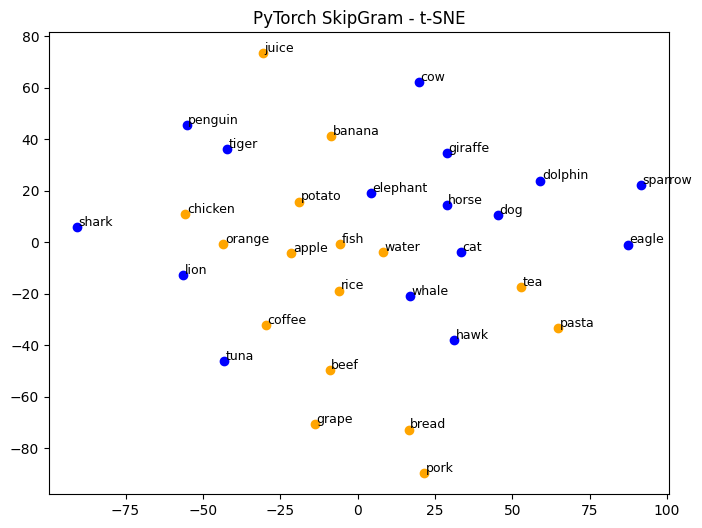

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


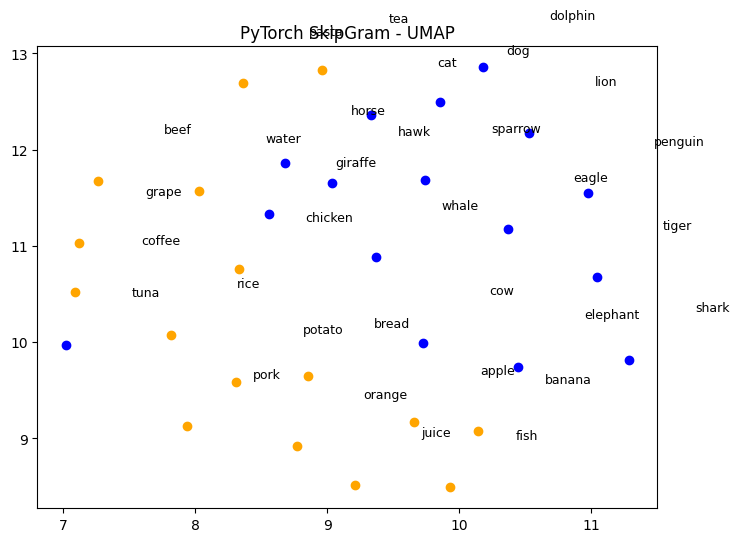

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


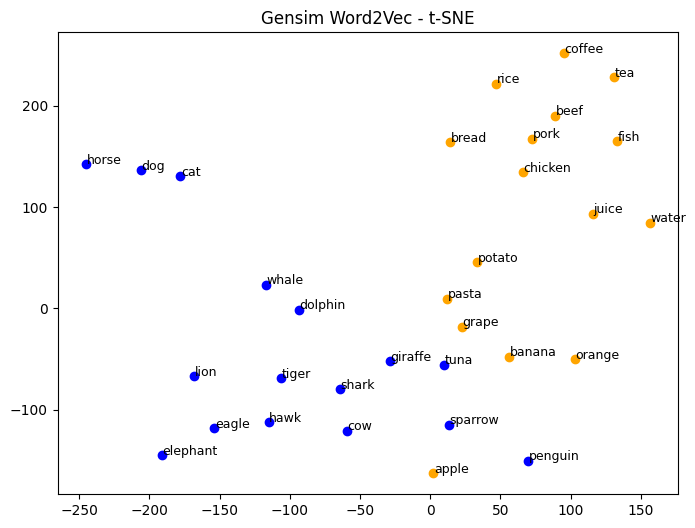

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


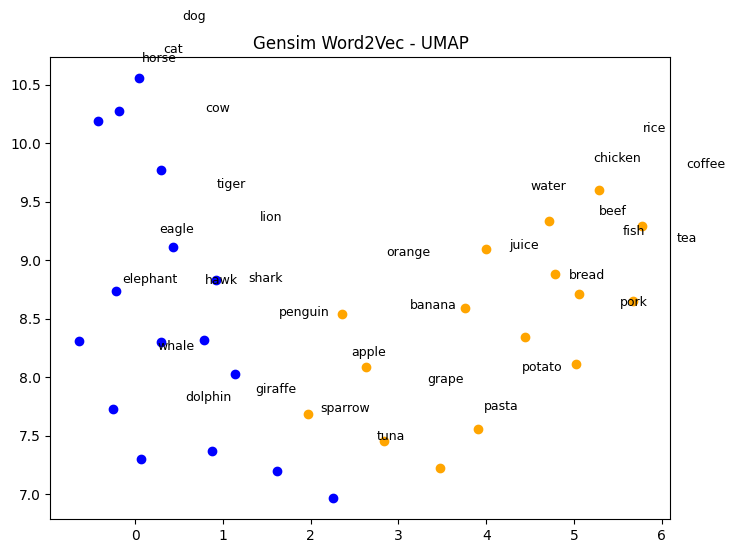

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


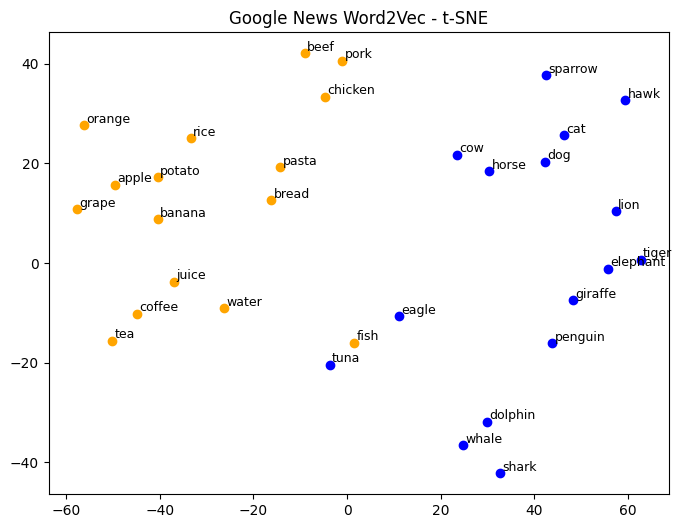

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


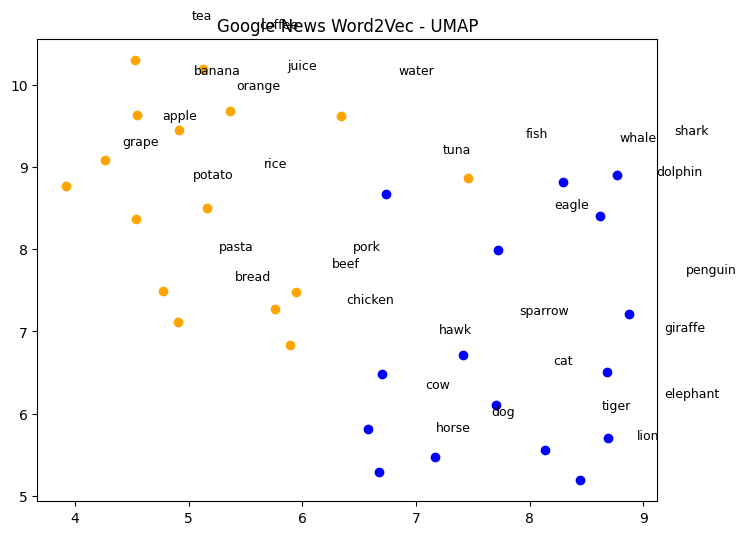

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


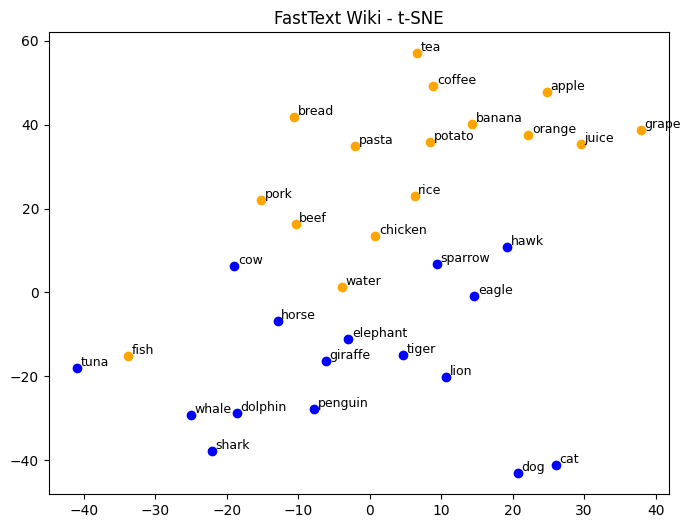

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


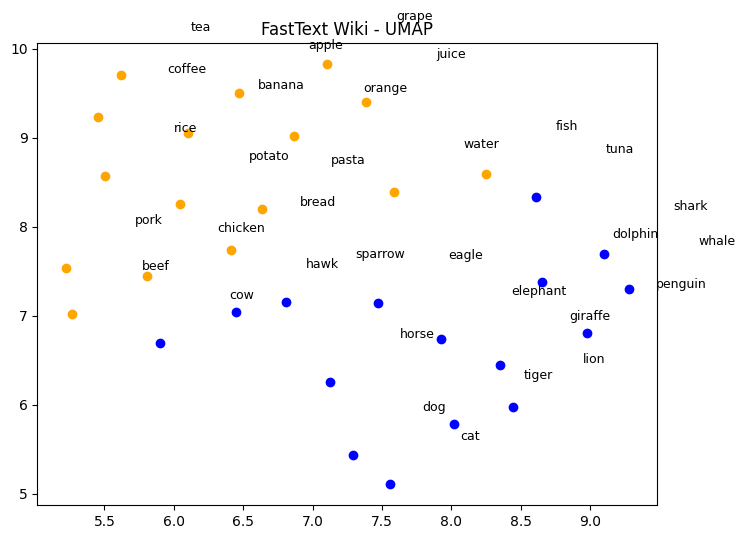

In [34]:
for name, (emb, word2idx, source_type) in embedding_sources.items():
    all_vectors = []
    all_labels = []
    all_colors = []
    for cat_name, (words, color) in categories.items():
        if source_type == 'pickle':
            vectors, valid_words = get_category_vectors(words, emb, word2idx)
        else:
            vectors, valid_words = get_category_vectors_gensim(words, emb)
        all_vectors.append(vectors)
        all_labels.extend(valid_words)
        all_colors.extend([color]*len(valid_words))
    all_vectors = np.vstack(all_vectors)

    tsne_result = tsne_umap(all_vectors, method='tsne')
    plot_embeddings(tsne_result, all_labels, all_colors, f"{name} - t-SNE")

    umap_result = tsne_umap(all_vectors, method='umap')
    plot_embeddings(umap_result, all_labels, all_colors, f"{name} - UMAP")

# Part 7: Short Answer Questions (10 points)

Which embeddings performed best at capturing sentence meaning?

- fastText performed best at capturing sentence meaning.

Were the pretrained embeddings significantly better than your own? Why or why not?
- The pretrained embeddings were significantly better than my own. The pretrained models are more accurate in the assessment of semantic similarity, and the clustering of the same semantic category in plots is tighter, while the boundaries between different categories are clearer.


What factors might explain the differences in performance?
- On the one hand, these pre-trained models use larger corpus, with richer context learning and co-occurrence statistics; on the other hand, pretrained models have undergone extensive hyperparameter tuning and multiple rounds of training, resulting in better training effects.

## AI Use Disclosure (Required)

If you used any AI-enabled tools (e.g., ChatGPT, GitHub Copilot, Claude, or other LLM assistants) while working on this assignment, you must disclose that use here. The goal is transparency-not punishment.

In your disclosure, briefly include:
- **Tool(s) used:** (name + version if known)
- **How you used them:** (e.g., concept explanation, debugging, drafting code, rewriting text)
- **What you verified yourself:** (e.g., reran the notebook, checked outputs/plots, checked shapes, read documentation)
- **What you did *not* use AI for (if applicable):** (optional)

You are responsible for the correctness of your submission, even if AI suggested code or explanations.

#### <font color="red">Write your disclosure here.</font>
- **Tool(s) used:** GPT-5.2
- **How you used them:** debugging, drafting code, rewriting text
- **What you verified yourself:** reran the notebook, checked outputs/plots, checked shapes, read documentation, write code, describe the conclusion
- **What you did *not* use AI for (if applicable):** (optional)